In [ ]:
import numpy as np
import pandas as pd
import os
import pickle
import math
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt

In [ ]:
data, info = tfds.load("imagenette/160px-v2", with_info=True, as_supervised=True)
train_data, valid_data = data['train'], data['validation']

del data

In [ ]:
train_dataset = train_data.map(
    lambda image, label: (tf.image.resize(image, (160, 160)), label))

validation_dataset = valid_data.map(
    lambda image, label: (tf.image.resize(image, (160, 160)), label)
)

del train_data
del valid_data

In [ ]:
num_classes = info.features['label'].num_classes
print(f'Total number of classes in dataset is {num_classes}')

Total number of classes in dataset is 10


In [ ]:
get_label_name = info.features['label'].int2str
text_labels = [get_label_name(i) for i in range(num_classes)]
for idx,i in enumerate(text_labels):
    print(f'The Label {idx} name is `{i}`')

The Label 0 name is `n01440764`
The Label 1 name is `n02102040`
The Label 2 name is `n02979186`
The Label 3 name is `n03000684`
The Label 4 name is `n03028079`
The Label 5 name is `n03394916`
The Label 6 name is `n03417042`
The Label 7 name is `n03425413`
The Label 8 name is `n03445777`
The Label 9 name is `n03888257`


In [ ]:
%%time

X_train = list(map(lambda x: x[0], train_dataset))
y_train = list(map(lambda x: x[1], train_dataset))


X_valid = list(map(lambda x: x[0], validation_dataset))
y_valid = list(map(lambda x: x[1], validation_dataset))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)

del train_dataset
del validation_dataset

CPU times: user 22.3 s, sys: 4.2 s, total: 26.5 s
Wall time: 32.2 s


In [ ]:
train_len = info.splits['train'].num_examples
valid_len = info.splits['validation'].num_examples
print(f'Train size {train_len} and Valid size {valid_len}')

Train size 9469 and Valid size 3925


In [ ]:
y_train.shape,y_valid.shape

((9469, 10), (3925, 10))

In [ ]:
%%time
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      height_shift_range=0.2)

valid_datagen = ImageDataGenerator(
      rescale=1./255)


train_ds = tf.keras.preprocessing.image.NumpyArrayIterator(
    x=preprocess_input(np.array(X_train)), y=np.array(y_train), image_data_generator=train_datagen,batch_size=16
)

valid_ds = tf.keras.preprocessing.image.NumpyArrayIterator(
    x=preprocess_input(np.array(X_valid)), y=np.array(y_valid), image_data_generator=valid_datagen,batch_size=32
)

# train_datagen.fit(X_train)

CPU times: user 1.87 s, sys: 1.11 s, total: 2.98 s
Wall time: 3 s


In [ ]:
train_ds.__len__(),valid_ds.__len__() #depends on batching

(592, 123)

In [ ]:
class CustomMLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        element_wise = tf.math.multiply_no_nan(x=y_true,
                                                   y=tf.math.divide_no_nan(x=tf.math.subtract(x=y_true, y=y_pred), y=y_pred))
        #element_wise = tf.math.add(x=tf.math.divide_no_nan(x=tf.math.subtract(x=y_true, y=y_pred), y=y_pred),
        #                   y=tf.math.divide_no_nan(x=tf.math.subtract(x=1.0, y=y_true), y=tf.math.subtract(x=1.0, y=y_pred)))
        return tf.reduce_mean(tf.reduce_sum(element_wise,axis=1))

class CustomLLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        element_wise = tf.math.divide_no_nan(x=y_true,
                                             y=tf.math.sqrt(
                                                 x=tf.math.subtract(x=1.0,
                                                                    y=tf.math.squared_difference(x=y_pred, y=1.0))
                                             ))

        return tf.reduce_mean(tf.reduce_sum(element_wise,axis=1))

class CustomLFullLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        element_wise = tf.math.subtract(x=tf.math.add(x=tf.math.divide_no_nan(x=y_true,
                                             y=tf.math.sqrt(
                                                 x=tf.math.subtract(x=1.0,
                                                                    y=tf.math.squared_difference(x=y_pred, y=1.0))
                                             )),
                                                      y=tf.math.divide_no_nan(x=tf.math.subtract(x=1.0,y=y_true),
                                                                              y=tf.math.sqrt(
                                                                                  tf.math.subtract(x=1.0,y=tf.math.square(y_pred))
                                                                              ))),
                                        y=1.0)

        return tf.reduce_mean(tf.reduce_sum(element_wise,axis=1))

class My_CE_Loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        log_y_pred = tf.math.log(y_pred)
        element_wise = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
        return tf.reduce_mean(tf.reduce_sum(element_wise,axis=1))

class ParabolicLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        element_wise = tf.math.multiply_no_nan(x=y_true,
                                                   y=tf.math.subtract(x=1.0, y=tf.math.square(y_pred)))
        return tf.reduce_mean(tf.reduce_sum(element_wise,axis=1))

class CircleLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        element_wise = tf.math.multiply_no_nan(x=y_true,
                                                   y=tf.math.sqrt(tf.math.subtract(x=1.0, y=tf.math.square(y_pred))))
        return tf.reduce_mean(tf.reduce_sum(element_wise,axis=1))

class CosLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        element_wise = tf.math.multiply_no_nan(y_true, tf.math.cos(tf.math.divide_no_nan(tf.math.multiply_no_nan(math.pi, y_pred), 2.0)))
        return tf.reduce_mean(tf.reduce_sum(element_wise,axis=1))

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import SGD, Adam

base_model = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3),
    classes=10
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='tanh')(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

opt = Adam(learning_rate=1e-5)
model.compile(optimizer=opt, loss=ParabolicLoss(), metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  steps_per_epoch=100,
  epochs=50,
  validation_steps=50,
  verbose=2
)

Epoch 1/50
100/100 - 38s - loss: 0.9795 - accuracy: 0.1215 - val_loss: 0.9580 - val_accuracy: 0.0862 - 38s/epoch - 383ms/step
Epoch 2/50


In [ ]:
print(f'The training accuracy was {round(history.history["accuracy"][-1],2)} and validation accuracy was {round(history.history["val_accuracy"][-1],2)} ')
print(f'The training loss was {round(history.history["loss"][-1],2)} and validation loss was {round(history.history["val_loss"][-1],2)} ')

The training accuracy was 0.75 and validation accuracy was 0.76 
The training loss was 2.98 and validation loss was 2.59 


In [ ]:
#L Full
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
test_loss, test_acc = model.evaluate(valid_ds, verbose=0)
print(f'The training accuracy was {round(train_acc,4)} and validation accuracy was {round(test_acc,4)} ')
print(f'The training loss was {round(train_loss,4)} and validation loss was {round(test_loss,4)} ')

The training accuracy was 0.7339 and validation accuracy was 0.7768 
The training loss was 3.019 and validation loss was 2.5389 


In [ ]:
#CE
train_loss, train_acc = model.evaluate(valid_ds, verbose=0)
test_loss, test_acc = model.evaluate(valid_ds, verbose=0)
print(f'The training accuracy was {round(train_acc,4)} and validation accuracy was {round(test_acc,4)} ')
print(f'The training loss was {round(train_loss,4)} and validation loss was {round(test_loss,4)} ')

The training accuracy was 0.7613 and validation accuracy was 0.7613 
The training loss was 0.8348 and validation loss was 0.8348 


## M Loss

In [ ]:
print(f'The training accuracy was {round(history.history["accuracy"][-1],2)} and validation accuracy was {round(history.history["val_accuracy"][-1],2)} ')
print(f'The training loss was {round(history.history["loss"][-1],2)} and validation loss was {round(history.history["val_loss"][-1],2)} ')

The training accuracy was 0.74 and validation accuracy was 0.78 
The training loss was 2.87 and validation loss was 2.55 


## M Full Loss

In [ ]:
print(f'The training accuracy was {round(history.history["accuracy"][-1],2)} and validation accuracy was {round(history.history["val_accuracy"][-1],2)} ')
print(f'The training loss was {round(history.history["loss"][-1],2)} and validation loss was {round(history.history["val_loss"][-1],2)} ')

The training accuracy was 0.74 and validation accuracy was 0.76 
The training loss was 3.94 and validation loss was 3.29 


## L Loss

In [ ]:
print(f'The training accuracy was {round(history.history["accuracy"][-1],2)} and validation accuracy was {round(history.history["val_accuracy"][-1],2)} ')
print(f'The training loss was {round(history.history["loss"][-1],2)} and validation loss was {round(history.history["val_loss"][-1],2)} ')

The training accuracy was 0.75 and validation accuracy was 0.77 
The training loss was 1.43 and validation loss was 1.37 


## L Full loss

In [ ]:
print(f'The training accuracy was {round(history.history["accuracy"][-1],2)} and validation accuracy was {round(history.history["val_accuracy"][-1],2)} ')
print(f'The training loss was {round(history.history["loss"][-1],2)} and validation loss was {round(history.history["val_loss"][-1],2)} ')

The training accuracy was 0.72 and validation accuracy was 0.78 
The training loss was 0.49 and validation loss was 0.41 


## My CE loss

In [ ]:
print(f'The training accuracy was {round(history.history["accuracy"][-1],2)} and validation accuracy was {round(history.history["val_accuracy"][-1],2)} ')
print(f'The training loss was {round(history.history["loss"][-1],2)} and validation loss was {round(history.history["val_loss"][-1],2)} ')

The training accuracy was 0.74 and validation accuracy was 0.74 
The training loss was 0.96 and validation loss was 0.86 


In [ ]:
my_ce_loss_dict = history.history
with open('my_ce_loss_dict.pickle', 'wb') as handle:
    pickle.dump(my_ce_loss_dict, handle)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


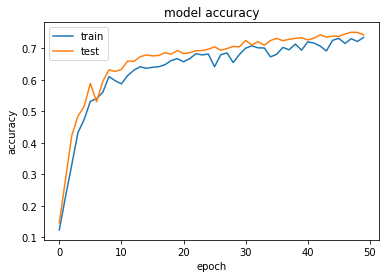

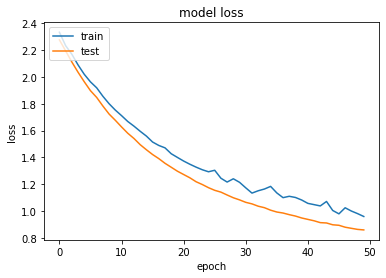

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()